# PHATE Biplot

In [1]:
import os
import requests
from io import BytesIO
import h5py
import numpy as np
from numpy.random import rand
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.image as mpimg
from matplotlib import animation
from PIL import Image
import pandas as pd
import seaborn as sns
import sklearn
import pickle
import phate
from sklearn import manifold
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import scipy.spatial
import scprep
import s_gd2
from IPython.display import HTML

os.chdir('../../src')
import mappings

Load data

In [2]:
# On Compute Canada, Cannot load from drive! Instead load a local copy
def load_from_drive(url):
    # Download the data
    response = requests.get(url)
    data = response.content

    # Load into a DataFrame
    df = pd.read_csv(BytesIO(data))
    df.set_index('Unnamed: 0', inplace=True)
    return df

# Download data and metadata from direct download links
#inputs = load_from_drive('https://drive.google.com/uc?export=download&id=1HjK4lGImHr1WKDaz3me8Jj7FJ72S0WzL')
#labels = load_from_drive('https://drive.google.com/uc?export=download&id=1egE-5_MaCbTjQeJn6fbogcBjlXAsxSrg')
#admix_ratios = load_from_drive('https://drive.google.com/uc?export=download&id=1mYHRCkToVDa2S0cQXKlHzKHDBqb75ozC')

def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

inputs = load_from_local('../data/1000G/1000G_PCA')
labels = load_from_local('../data/1000G/1000G_labels')
admix_ratios = load_from_local('../data/1000G/1000G_admix_ratios')

In [3]:
idx_order = []
for label in mappings.label_order_1000G_fine:
    idx_order.extend(labels[(labels['population'] == label)].index)
    
inputs = inputs.loc[idx_order]
labels = labels.loc[idx_order]

We fit PHATE to the thousand genomes dataset.

In [4]:
# initial 2D phate embedding
random_state = 42
n_components = 2
t = 15 # increase t when not using landmarks
knn = 5
decay = 60
phate_op = phate.PHATE(random_state=random_state,
                       n_components=n_components,
                       knn=knn,
                       n_pca=None,
                       n_landmark=None,
                       decay=decay,
                       t=t)
phate_op.fit(inputs.values)
phate_embedding = phate_op.transform()

Running PHATE on 2504 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.46 seconds.
  Calculating affinities...
  Calculated affinities in 0.13 seconds.
Calculated graph and diffusion operator in 0.63 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 4.13 seconds.
Calculating metric MDS...
Calculated metric MDS in 10.49 seconds.


<Axes: title={'center': 'PHATE '}, xlabel='PHATE 1', ylabel='PHATE 2'>

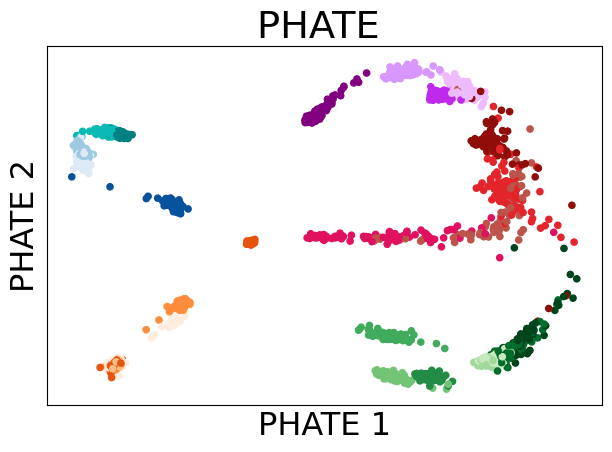

In [5]:
scprep.plot.scatter2d(phate_embedding, s=20,
                      cmap=mappings.pop_pallette_1000G_fine, c=labels['population'],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", title='PHATE ', fontsize=16)

Lets look at the effect of diffusing over the Markov transition matrix

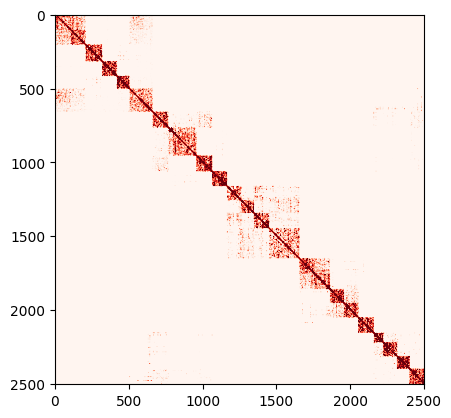

In [6]:
p_arr = phate_op.graph.P.todense()
plt.imshow(p_arr, cmap='Reds', vmin=p_arr.min(), vmax=0.01)

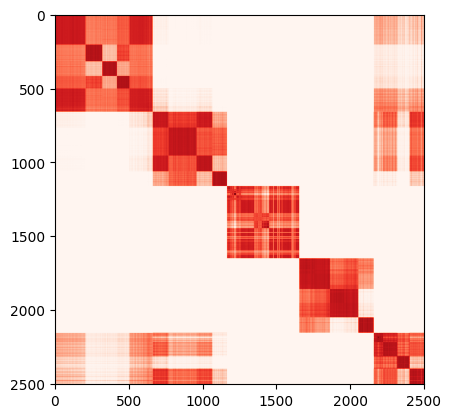

In [7]:
diff_potential = phate_op._calculate_potential(plot_optimal_t=False)
plt.imshow(diff_potential, cmap='Reds_r', vmin=diff_potential.min(), vmax=diff_potential.max()) 

In [8]:
# MDS embeddings, each gives a different output.
X_dist = squareform(pdist(diff_potential, "euclidean"))

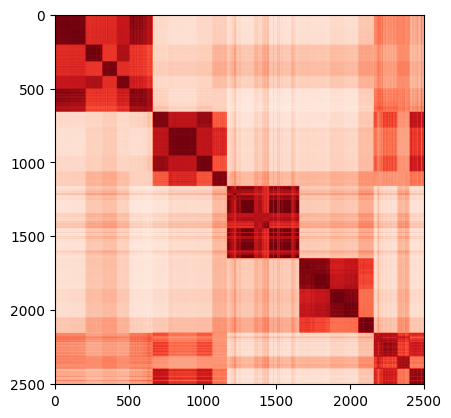

In [9]:
plt.imshow(X_dist, cmap='Reds_r', vmin=X_dist.min(), vmax=X_dist.max())

Now we decompose the tranform step.

We want to see how it changes at each iteration of MDS.

In [10]:
def sgd(D, n_components=2, random_state=None, init=None):
    """Metric MDS using stochastic gradient descent

    Parameters
    ----------
    D : array-like, shape=[n_samples, n_samples]
        pairwise distances

    n_components : int, optional (default: 2)
        number of dimensions in which to embed `D`

    random_state : int or None, optional (default: None)
        numpy random state

    init : array-like or None
        Initialization algorithm or state to use for MMDS

    Returns
    -------
    Y : array-like, embedded data [n_sample, ndim]
    """
    if not n_components == 2:
        raise NotImplementedError
    N = D.shape[0]
    D = squareform(D)
    # Metric MDS from s_gd2
    Y = s_gd2.mds_direct(N, D, init=init, random_seed=random_state)
    return Y


def smacof(
    D,
    n_components=2,
    metric=True,
    init=None,
    random_state=None,
    verbose=0,
    max_iter=3000,
    eps=1e-6,
    n_jobs=1,
):
    """Metric and non-metric MDS using SMACOF

    Parameters
    ----------
    D : array-like, shape=[n_samples, n_samples]
        pairwise distances

    n_components : int, optional (default: 2)
        number of dimensions in which to embed `D`

    metric : bool, optional (default: True)
        Use metric MDS. If False, uses non-metric MDS

    init : array-like or None, optional (default: None)
        Initialization state

    random_state : int, RandomState or None, optional (default: None)
        numpy random state

    verbose : int or bool, optional (default: 0)
        verbosity

    max_iter : int, optional (default: 3000)
        maximum iterations

    eps : float, optional (default: 1e-6)
        stopping criterion

    Returns
    -------
    Y : array-like, shape=[n_samples, n_components]
        embedded data
    """

    # Metric MDS from sklearn
    Y, _ = manifold.smacof(
        D,
        n_components=n_components,
        metric=metric,
        max_iter=max_iter,
        eps=eps,
        random_state=random_state,
        n_jobs=n_jobs,
        n_init=1,
        init=init,
        verbose=verbose,
        normalized_stress='auto', # suppress warning
    )
    return Y


def classic(D, n_components=2, random_state=None):
    """Fast CMDS using random SVD

    Parameters
    ----------
    D : array-like, shape=[n_samples, n_samples]
        pairwise distances

    n_components : int, optional (default: 2)
        number of dimensions in which to embed `D`

    random_state : int, RandomState or None, optional (default: None)
        numpy random state

    Returns
    -------
    Y : array-like, embedded data [n_sample, ndim]
    """
    D = D**2
    D = D - D.mean(axis=0)[None, :]
    D = D - D.mean(axis=1)[:, None]
    pca = PCA(
        n_components=n_components, svd_solver="randomized", random_state=random_state
    )
    Y = pca.fit_transform(D)
    return Y


def embed_MDS(
    X,
    ndim=2,
    how="metric",
    distance_metric="euclidean",
    solver="sgd",
    max_iter=3000,
    n_jobs=1,
    seed=None,
    verbose=0,
):
    """Performs classic, metric, and non-metric MDS

    Metric MDS is initialized using classic MDS,
    non-metric MDS is initialized using metric MDS.

    Parameters
    ----------
    X: ndarray [n_samples, n_features]
        2 dimensional input data array with n_samples

    n_dim : int, optional, default: 2
        number of dimensions in which the data will be embedded

    how : string, optional, default: 'classic'
        choose from ['classic', 'metric', 'nonmetric']
        which MDS algorithm is used for dimensionality reduction

    distance_metric : string, optional, default: 'euclidean'
        choose from ['cosine', 'euclidean']
        distance metric for MDS

    solver : {'sgd', 'smacof'}, optional (default: 'sgd')
        which solver to use for metric MDS. SGD is substantially faster,
        but produces slightly less optimal results. Note that SMACOF was used
        for all figures in the PHATE paper.

    n_jobs : integer, optional, default: 1
        The number of jobs to use for the computation.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging.
        For n_jobs below -1, (n_cpus + 1 + n_jobs) are used. Thus for
        n_jobs = -2, all CPUs but one are used

    seed: integer or numpy.RandomState, optional
        The generator used to initialize SMACOF (metric, nonmetric) MDS
        If an integer is given, it fixes the seed
        Defaults to the global numpy random number generator

    Returns
    -------
    Y : ndarray [n_samples, n_dim]
        low dimensional embedding of X using MDS
    """

    if how not in ["classic", "metric", "nonmetric"]:
        raise ValueError(
            "Allowable 'how' values for MDS: 'classic', "
            "'metric', or 'nonmetric'. "
            "'{}' was passed.".format(how)
        )
    if solver not in ["sgd", "smacof"]:
        raise ValueError(
            "Allowable 'solver' values for MDS: 'sgd' or "
            "'smacof'. "
            "'{}' was passed.".format(solver)
        )

    # MDS embeddings, each gives a different output.
    X_dist = squareform(pdist(X, distance_metric))

    # initialize all by CMDS
    Y_classic = classic(X_dist, n_components=ndim, random_state=seed)
    if how == "classic":
        return Y_classic, None

    # metric is next fastest
    if solver == "sgd":
        try:
            # use sgd2 if it is available
            Y = sgd(X_dist, n_components=ndim, random_state=seed, init=Y_classic)
            if np.any(~np.isfinite(Y)):
                raise NotImplementedError
        except NotImplementedError:
            # sgd2 currently only supports n_components==2
            Y = smacof(
                X_dist,
                n_components=ndim,
                random_state=seed,
                init=Y_classic,
                metric=True,
                max_iter=max_iter,
            )
    elif solver == "smacof":
        Y = smacof(
            X_dist, n_components=ndim, random_state=seed, init=Y_classic, metric=True
        )
    else:
        raise RuntimeError
    if how == "metric":
        # re-orient to classic
        _, Y, _ = scipy.spatial.procrustes(Y_classic, Y)
        return Y, Y_classic

    # nonmetric is slowest
    Y = smacof(X_dist, n_components=ndim, random_state=seed, init=Y, metric=False)
    # re-orient to classic
    _, Y, _ = scipy.spatial.procrustes(Y_classic, Y)
    return Y, Y_classic

In [11]:
# transform

#embedding, embedding_classic = embed_MDS(
#                    diff_potential,
#                    ndim=2,
#                    how="metric",
#                    solver='smacof',
#                    max_iter=3000,
#                    distance_metric="euclidean",
#                    n_jobs=8,
#                    seed=42,
#                    verbose=3,
#                )
#phate_embedding = phate_op.transform()

 # initialize all by CMDS
Y_classic = classic(X_dist, n_components=2, random_state=42)

embeddings = [Y_classic]
for i in range(100): # resolution of 100
    Y = smacof(
        X_dist,
        n_components=2,
        random_state=42,
        init=embeddings[-1],
        metric=True,
        max_iter=1, # run 10 steps
    )
    embeddings.append(Y)

Compute embedding distances at each iteration

In [ ]:
transitions = phate_operator.graph.extend_to_data(pca_input_mhi)
phate_operator.graph.interpolate(phate_operator.embedding, transitions)